<a href="https://colab.research.google.com/github/harikiran1459/cervical_spine_fracture_detection/blob/main/cervical_spine_fracture_prediction_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!unzip archive.zip
%ls

Archive:  archive.zip
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-rotated3-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-rotated3-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B11 (1)-rotated1-rotated1.png  
  inflating: cervical fracture/train/fracture/CSFD

In [29]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [30]:
train_path= '/content/cervical fracture/train'
test_path='/content/cervical fracture/val'

In [31]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [32]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 3800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [33]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','AUC'])

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lrp=ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2)
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
call=[checkpoint,lrp]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch= 50,
    callbacks=call
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 0.5531 - Precision: 0.4743 - Recall: 0.5117 - accuracy: 0.5321 - loss: 0.9142
Epoch 1: val_accuracy improved from -inf to 0.56750, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 663ms/step - AUC: 0.5554 - Precision: 0.4762 - Recall: 0.5137 - accuracy: 0.5339 - loss: 0.9116 - val_AUC: 0.6630 - val_Precision: 0.7077 - val_Recall: 0.2300 - val_accuracy: 0.5675 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - AUC: 0.7452 - Precision: 0.6278 - Recall: 0.5899 - accuracy: 0.6527 - loss: 0.6106
Epoch 2: val_accuracy improved from 0.56750 to 0.74500, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 655ms/step - AUC: 0.7465 - Precision: 0.6296 - Recall: 0.5916 - accuracy: 0.6541 - loss: 0.6094 - val_AUC: 0.8518 - val_Precision: 0.7722 - val_Recall: 0.6950 - val_accuracy: 0.7450 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/ste

In [37]:
model.evaluate(train_generator)

950/950 ━━━━━━━━━━━━━━━━━━━━ 192s 202ms/step - AUC: 0.9723 - Precision: 0.9349 - Recall: 0.8626 - accuracy: 0.9047 - loss: 0.2435


[0.24184605479240417,
 0.9081578850746155,
 0.9444125890731812,
 0.8673684000968933,
 0.973901093006134]

In [38]:
model.evaluate(validation_generator)

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - AUC: 0.9130 - Precision: 0.8417 - Recall: 0.8060 - accuracy: 0.8132 - loss: 0.4373


[0.4376649558544159,
 0.8324999809265137,
 0.8375634551048279,
 0.824999988079071,
 0.9148625135421753]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.05432915]]
THE UPLOADED SPINE CT IMAGE IS: Fracture


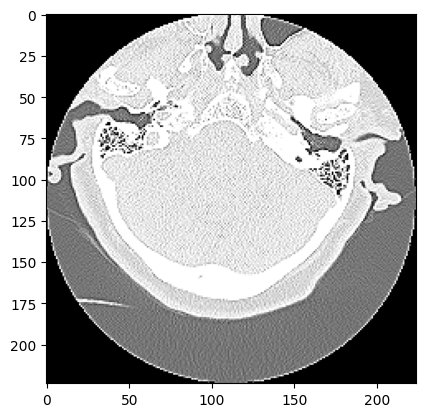

In [40]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/content/cervical fracture/val/fracture/CSFDV1B10 (11)-sharpened.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Fracture"
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED SPINE CT IMAGE IS: "+str(op))